In [6]:
import pandas as pd
import geopandas as gpd

# File paths
rental_data_path = '/home/Daniel Bi/project two/data/landing/rental_merged.csv'
train_station_shapefile_path = '/home/Daniel Bi/project two/data/landing/PTV_train_station/PTV/PTV_METRO_TRAIN_STATION.shp'

# Step 1: Load the rental data
rental_df = pd.read_csv(rental_data_path)

# Step 2: Load the train station data from shapefile
train_station_gdf = gpd.read_file(train_station_shapefile_path)

# Step 3: Clean the train station names by removing "Railway Station" or "Station"
def clean_station_name(station_name):
    cleaned = station_name.replace("Railway Station", "").replace("Station", "").strip()
    return cleaned

train_station_gdf['Cleaned_Station_Name'] = train_station_gdf['STOP_NAME'].apply(clean_station_name)

# Step 4: Ensure both train station and rental data suburbs are in lowercase for matching, without modifying original columns
train_station_gdf['Cleaned_Station_Name'] = train_station_gdf['Cleaned_Station_Name'].str.lower()

# Step 5: Create a function to check if any train station belongs to the suburb
def has_train_station(suburb, train_station_names):
    # Make sure the suburb is lowercase for matching purposes, without altering the original column
    suburb_lower = suburb.lower()
    return any(suburb_lower in station for station in train_station_names)

# Apply the function to add the 'has_train_station' column
train_station_names = train_station_gdf['Cleaned_Station_Name'].tolist()
rental_df['has_train_station'] = rental_df['Suburb'].apply(lambda x: 1 if has_train_station(x, train_station_names) else 0)

# Step 6: Save the updated rental data back to 'rental_merged.csv'
output_path = '/home/Daniel Bi/project two/data/landing/rental_merged.csv'
rental_df.to_csv(output_path, index=False)

# Display the first few rows to confirm the addition of the new feature
print(rental_df[['Suburb', 'has_train_station']].head())




       Suburb  has_train_station
0  Mordialloc                  1
1   Doncaster                  0
2  Noble Park                  1
3      Albion                  1
4    Sunshine                  1


adding count of hospital

In [23]:
import pandas as pd
import re

# File paths
merged_data_path = '/home/Daniel Bi/project two/data/landing/rental_merged.csv'
hospital_data_path = '/home/Daniel Bi/project two/data/landing/hospital_count.csv'

# Step 1: Load the merged dataset
merged_df = pd.read_csv(merged_data_path)

# Step 2: Load the hospital dataset
hospital_df = pd.read_csv(hospital_data_path)

# Function to clean and standardize suburb names
def clean_suburb_name(name):
    if pd.isnull(name):
        return name
    # Convert to lowercase and remove any non-alphabetical characters (punctuation, extra spaces)
    name = name.lower()
    name = re.sub(r'[^a-z\s]', '', name)  # Remove punctuation
    name = re.sub(r'\s+', ' ', name).strip()  # Remove extra spaces
    return name

# Step 3: Clean the 'Suburb' column in the merged dataset and 'SA2_NAME21' column in the hospital dataset
merged_df['Suburb_cleaned'] = merged_df['Suburb'].apply(clean_suburb_name)
hospital_df['SA2_NAME21_cleaned'] = hospital_df['SA2_NAME21'].apply(clean_suburb_name)

# Step 4: Remove any existing 'hospital_count' column from the merged dataset if it exists
if 'hospital_count' in merged_df.columns:
    merged_df.drop(columns=['hospital_count'], inplace=True)

# Step 5: Merge the datasets based on the cleaned columns
merged_df_with_hospital = pd.merge(merged_df, hospital_df[['SA2_NAME21_cleaned', 'hospital_count']], 
                                   left_on='Suburb_cleaned', right_on='SA2_NAME21_cleaned', how='left')

# Step 6: Drop the unnecessary columns
merged_df_with_hospital.drop(columns=['SA2_NAME21_cleaned', 'Suburb_cleaned'], inplace=True)

# Step 7: Save the updated merged dataset
output_path = '/home/Daniel Bi/project two/data/landing/rental_merged.csv'
merged_df_with_hospital.to_csv(output_path, index=False)

# Step 8: Display the first few rows to confirm
print(merged_df_with_hospital.head())


     SA2 code  Unnamed: 0  property_index   Cost  Beds  Baths  Cars  \
0   208031193           0               0  560.0     2      1   1.0   
1   207021157           1               1  550.0     2      1   1.0   
2   212041459           2               2  340.0     1      1   1.0   
3   213011328           3               4  460.0     3      1   NaN   
4   213011336           4               5  270.0     1      1   1.0   
5   203021487           5               6  800.0     4      2   2.0   
6   206061136           6               7  875.0     3      1   1.0   
7   206041510           7               8  575.0     1      1   NaN   
8   206071517           8               9    NaN     2      1   1.0   
9   212041460           9              10  600.0     3      1   2.0   
10  208021177          10              11  749.0     3      1   NaN   
11  206061515          11              12  695.0     2      1   1.0   
12  208031190          12              13  850.0     4      2   3.0   
13  21

In [25]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# File path for the merged dataset
rental_data_path = '/home/Daniel Bi/project two/data/landing/rental_merged.csv'

# Step 1: Load the dataset
df = pd.read_csv(rental_data_path)

# Step 2: Affordability metric - calculate affordability as the ratio of income to rental cost
df['affordability_ratio'] = df['value_2019'] / df['Cost']

# Step 3: Liveability metrics (updated column names for school counts and added hospital_count)
liveability_features = df[['has_train_station', 'parks_count', 'shopping_count', 'Independent_School_Count', 'Non_Independent_School_Count', 'hospital_count']]

# Step 4: Normalize the liveability features using RobustScaler
scaler = RobustScaler()
liveability_scaled = scaler.fit_transform(liveability_features)

# Add normalized liveability columns to the DataFrame
df['norm_has_train_station'] = liveability_scaled[:, 0]
df['norm_parks_count'] = liveability_scaled[:, 1]
df['norm_shopping_count'] = liveability_scaled[:, 2]
df['norm_Independent_School_Count'] = liveability_scaled[:, 3]
df['norm_Non_Independent_School_Count'] = liveability_scaled[:, 4]
df['norm_hospital_count'] = liveability_scaled[:, 5]

# Step 5: Calculate the overall liveability score
df['liveability_score'] = (
    df['norm_has_train_station'] * 0.17 +
    df['norm_parks_count'] * 0.17 +
    df['norm_shopping_count'] * 0.17 +
    df['norm_Independent_School_Count'] * 0.17 +
    df['norm_Non_Independent_School_Count'] * 0.17 +
    df['norm_hospital_count'] * 0.15
)

# Step 6: Group by suburb and calculate the mean of affordability and liveability
grouped_df = df.groupby('Suburb').agg({
    'affordability_ratio': 'mean',
    'liveability_score': 'mean'
}).reset_index()

# Step 7: Calculate the overall score (you can adjust the weights as needed)
# Give equal weight to affordability and liveability for the overall score
grouped_df['overall_score'] = (grouped_df['affordability_ratio'] * 0.5) + (grouped_df['liveability_score'] * 0.5)

# Step 8: Sort by the overall score to find the top 10 suburbs
top_overall_suburbs = grouped_df.sort_values('overall_score', ascending=False)[['Suburb', 'overall_score']].head(10)

# Output the top 10 overall suburbs
print("Top 10 Overall Suburbs (Affordability + Liveability):")
print(top_overall_suburbs)

# Step 9: Sort by affordability and liveability individually
top_affordable_suburbs = grouped_df.sort_values('affordability_ratio', ascending=False)[['Suburb', 'affordability_ratio']].head(10)
top_liveable_suburbs = grouped_df.sort_values('liveability_score', ascending=False)[['Suburb', 'liveability_score']].head(10)

# Output top 10 affordability and liveability suburbs
print("\nTop 10 Affordable Suburbs:")
print(top_affordable_suburbs)

print("\nTop 10 Liveable Suburbs:")
print(top_liveable_suburbs)

# Step 10: Save the updated dataset with liveability, affordability, and overall scores
output_path = '/home/Daniel Bi/project two/data/landing/rental_with_liveability_affordability.csv'
df.to_csv(output_path, index=False)

# Optional: Save the overall scores to a CSV
overall_output_path = '/home/Daniel Bi/project two/data/landing/rental_with_overall_scores.csv'
grouped_df.to_csv(overall_output_path, index=False)




Top 10 Overall Suburbs (Affordability + Liveability):
              Suburb  overall_score
318    Smythes Creek      31.510106
24     Bacchus Marsh      16.304603
83   Caulfield North      15.075662
225      Maribyrnong      13.146365
151          Geelong       6.475048
207             Lara       5.092221
48          Box Hill       1.591691
180          Highton       1.520976
147        Frankston       1.358864
129      Elsternwick       1.277275

Top 10 Affordable Suburbs:
              Suburb  affordability_ratio
158        Glen Iris            68.939031
318    Smythes Creek            63.269444
329         St Kilda            53.168956
230        Melbourne            51.797643
24     Bacchus Marsh            31.699821
83   Caulfield North            29.950431
225      Maribyrnong            26.328003
217            Lucas            22.713026
222        Mambourin            18.042323
119       Donnybrook            17.147722

Top 10 Liveable Suburbs:
            Suburb  liveability_sc

Visulisation of top ten liveable, top ten affordable and top ten overall

/tmp/ipykernel_700800/413598100.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='affordability_ratio', y='Suburb', data=top_affordable_suburbs, ax=axes[0], palette='Blues_d')
/tmp/ipykernel_700800/413598100.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='liveability_score', y='Suburb', data=top_liveable_suburbs, ax=axes[1], palette='Greens_d')
/tmp/ipykernel_700800/413598100.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='overall_score', y='Suburb', data=top_overall_suburbs, ax=axes[2], palette='Purples_d')


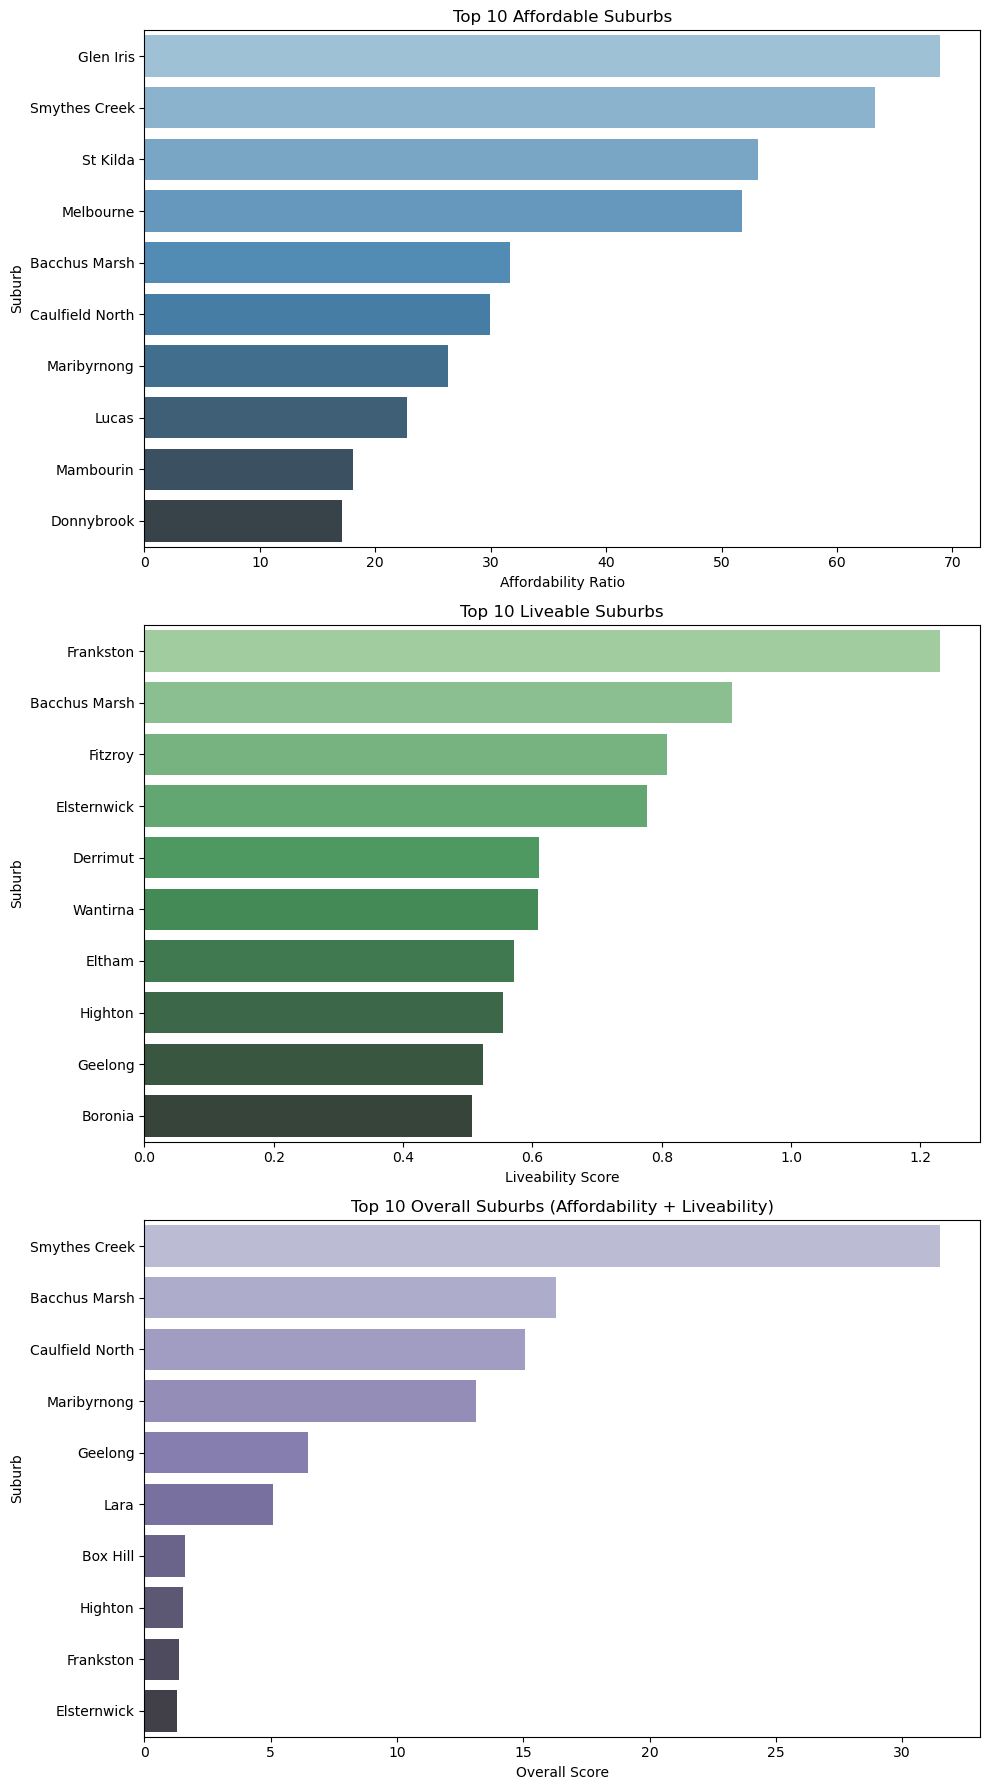

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path for the dataset with rankings
grouped_data_path = '/home/Daniel Bi/project two/data/landing/rental_with_overall_scores.csv'

# Step 1: Load the dataset
grouped_df = pd.read_csv(grouped_data_path)

# Step 2: Extract the top 10 suburbs for affordability, liveability, and overall score
top_affordable_suburbs = grouped_df.sort_values('affordability_ratio', ascending=False)[['Suburb', 'affordability_ratio']].head(10)
top_liveable_suburbs = grouped_df.sort_values('liveability_score', ascending=False)[['Suburb', 'liveability_score']].head(10)
top_overall_suburbs = grouped_df.sort_values('overall_score', ascending=False)[['Suburb', 'overall_score']].head(10)

# Step 3: Set up the figure for multiple plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Step 4: Plot the top 10 affordable suburbs
sns.barplot(x='affordability_ratio', y='Suburb', data=top_affordable_suburbs, ax=axes[0], palette='Blues_d')
axes[0].set_title('Top 10 Affordable Suburbs')
axes[0].set_xlabel('Affordability Ratio')
axes[0].set_ylabel('Suburb')

# Step 5: Plot the top 10 liveable suburbs
sns.barplot(x='liveability_score', y='Suburb', data=top_liveable_suburbs, ax=axes[1], palette='Greens_d')
axes[1].set_title('Top 10 Liveable Suburbs')
axes[1].set_xlabel('Liveability Score')
axes[1].set_ylabel('Suburb')

# Step 6: Plot the top 10 overall suburbs
sns.barplot(x='overall_score', y='Suburb', data=top_overall_suburbs, ax=axes[2], palette='Purples_d')
axes[2].set_title('Top 10 Overall Suburbs (Affordability + Liveability)')
axes[2].set_xlabel('Overall Score')
axes[2].set_ylabel('Suburb')

# Step 7: Adjust layout for better appearance
plt.tight_layout()

# Step 9: Show the plot
plt.show()
